This is an example script for running the microcircuit model and generating basic plots of the network activity.

Import the necessary modules and start the time measurements.

THE COLOR PALETTE

#d53e4f
#f46d43
#fdae61
#fee08b
#e6f598
#abdda4
#66c2a5
#3288bd

In [1]:
import nest
import network
import addons
import numpy as np
from network_params import net_dict
from sim_params import sim_dict
from stimulus_params import stim_dict


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



/home/hyc_1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning:Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


Initialize the network with simulation, network and stimulation parameters, then create and connect all nodes, and finally simulate. The times for a presimulation and the main simulation are taken independently. A presimulation is useful because the spike activity typically exhibits a startup transient. In benchmark simulations, this transient should be excluded from a time measurement of the state propagation phase. Besides, statistical measures of the spike activity should only be computed after the transient has passed.

In [2]:
record_synapses = False

net = network.Network(sim_dict, net_dict, stim_dict)
net.create()
net.connect()

if record_synapses:
    data_synapses = addons.number_synapses(net.pops)

net.simulate(sim_dict["t_presim"])
net.simulate(sim_dict["t_sim"])

Data will be written to: /home/hyc_1/CorticalColumn_Github_1/CorticalColumn_Attempts/data_og/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Sep 08 13:32:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating Poisson generators for background input.
Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(metadata=None, model=iaf_psc_exp, size=1065

Plot a spike raster of the simulated neurons and a box plot of the firing rates for each population. For visual purposes only, spikes 100 ms before and 100 ms after the thalamic stimulus time are plotted here by default. The computation of spike rates discards the presimulation time to exclude initialization artifacts.

Interval to plot spikes: [500 900] ms
[5.6487e+04 5.0653e+04 2.8738e+04 2.3259e+04 1.8409e+04 1.7344e+04
 2.9490e+03 1.0000e+00]
  Only spikes of neurons in steps of 1 are shown.
Directory already existed
Directory already existed
Interval to compute firing rates: [  500 60500] ms
Mean rates: [0.035 0.102 0.143 0.185 0.214 0.273 0.02  0.242] spikes/s
Standard deviation of rates: [0.043 0.082 0.108 0.132 0.152 0.171 0.035 0.156] spikes/s


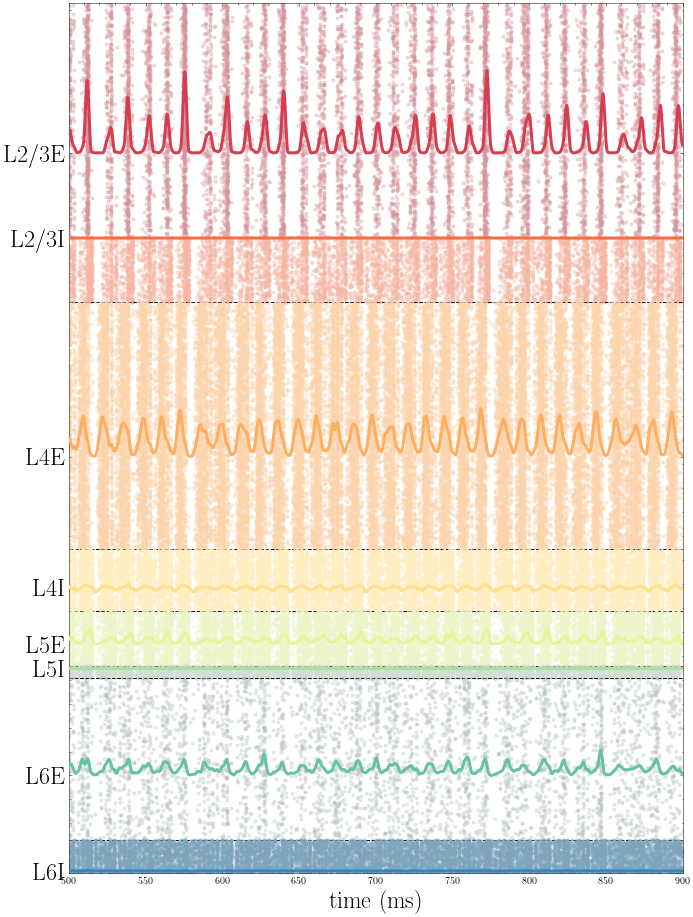

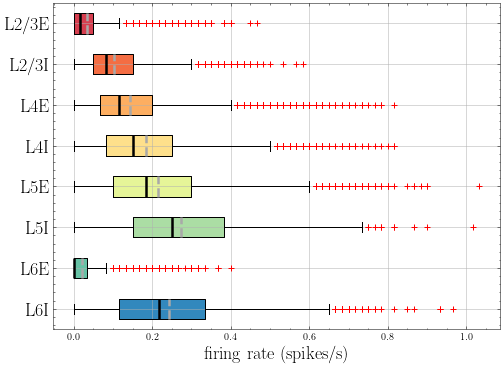

In [3]:
raster_plot_interval = np.array([500, 900])
firing_rates_interval = np.array([500,60500])
pop_activity = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True,trial=0)